In [2]:
"""
Generates data for training
"""
import numpy as np

from qutip.visualization import plot_wigner, hinton, plot_fock_distribution
from qutip import Qobj, fidelity
from qutip.wigner import qfunc, wigner
from qutip.states import thermal_dm
from qutip.random_objects import rand_dm
from qutip import coherent_dm, destroy, mesolve, Options, fock_dm, coherent, expect
from qutip.visualization import plot_wigner_fock_distribution
from qutip.wigner import qfunc


import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from qst_nn.ops import cat, binomial, num, gkp, GaussianConv, husimi_ops, convert_to_real_ops, dm_to_tf, batched_expect



import h5py

from skimage.util import random_noise
from skimage import transform
from skimage.filters import gaussian


from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import colors

In [3]:
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {
          'axes.labelsize': 9,
          'font.size': 9,
          'legend.fontsize': 9,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'axes.labelpad':1,
          'legend.handlelength':0.8,
          'axes.titlesize': 9,
    "text.usetex"        : False
          }
plt.rcParams.update(params)

# mpl.use('pdf')

In [4]:
hilbert_size = 32


# Betas can be selected in a grid or randomly in a circle
num_grid = 81
num_points = num_grid*num_grid
beta_max_x = 5
beta_max_y = 5

xvec = np.linspace(-beta_max_x, beta_max_x, num_grid)
yvec = np.linspace(-beta_max_y, beta_max_y, num_grid)

X, Y = np.meshgrid(xvec, yvec)
betas = (X + 1j*Y).ravel()

ops = husimi_ops(hilbert_size, betas)
ops_batch = tf.convert_to_tensor([ops])
A = convert_to_real_ops(ops_batch)

2021-09-24 17:26:56.726973: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
cmap = "hot"

In [6]:
# define normalized 2D gaussian
def gaus2d(x=0, y=0, n0=1):
    return 1. / (np.pi * n0) * np.exp(-((x**2 + y**2.0)/n0))

nth = 5
X, Y = np.meshgrid(xvec, yvec) # get 2D variables instead of 1D
gauss_kernel = gaus2d(X, Y, n0=nth)

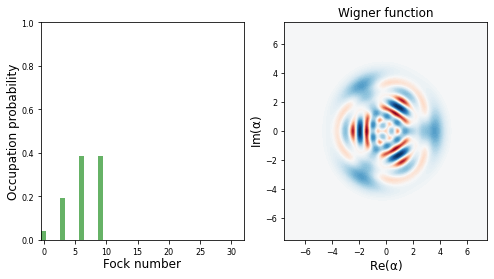

In [7]:
rho, _ = binomial(hilbert_size, 2, 4, 0)
plot_wigner_fock_distribution(rho)
plt.show()

In [9]:

rho_tf = dm_to_tf([rho])
data = batched_expect(ops_batch, rho_tf)

In [10]:
# Convolve.


In [11]:
x = tf.reshape(tf.cast(data, tf.float64), (1, num_grid, num_grid, 1))

conved = GaussianConv(gauss_kernel)(x)

kernel = gauss_kernel/tf.reduce_max(gauss_kernel)
diff = conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(conved) - kernel.numpy().reshape(num_grid, num_grid)
diff = tf.convert_to_tensor(diff)

matrices = [gauss_kernel.reshape((num_grid, num_grid)), x.numpy().reshape((num_grid, num_grid)), 
           conved.numpy().reshape((num_grid, num_grid)), diff.numpy().reshape((num_grid, num_grid))]

In [12]:
datapath = "data/"
fname = datapath+"states-convolution-noise-binomial.npy"
states_list = np.load(fname)

rho_tf = dm_to_tf([Qobj(states_list[-1])])
data_reconstructed = batched_expect(ops_batch, rho_tf)

reconstructed_x = tf.reshape(tf.cast(data_reconstructed, tf.float64), (1, num_grid, num_grid, 1))

reconstructed_conved = GaussianConv(gauss_kernel)(reconstructed_x)

diff2 = reconstructed_conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(reconstructed_conved) - kernel.numpy().reshape(num_grid, num_grid)

In [13]:
matrices2 = [gauss_kernel.reshape((num_grid, num_grid)), reconstructed_x.numpy().reshape((num_grid, num_grid)), 
           reconstructed_conved.numpy().reshape((num_grid, num_grid)), diff2.numpy().reshape((num_grid, num_grid))]

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/1676423528.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(xvec, yvec,
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/1676423528.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(["", "", ""])
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/1676423528.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(["", "", ""], fontsize=6)
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/1676423528.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax

Text(-44.5, 30, '(b)')

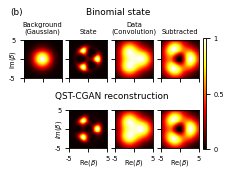

In [14]:
figpath = "figures/"

fig, ax = plt.subplots(2, 4, figsize=(fig_width, 0.35*2.5*fig_height), dpi=80, facecolor="white",
                             sharey=False, sharex=True)

axes = [ax[0, 0], ax[0, 1], ax[0, 2], ax[0, 3]]

aspect = 'equal'

for i in range(4):
    im = axes[i].pcolor(xvec, yvec,
                   matrices[i]/np.max(matrices[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["", "", ""])
    axes[i].set_yticklabels(["", "", ""], fontsize=6)
    # axes[i].set_xlabel(r"$Re(\beta)$", fontsize=6)    
axes[0].set_yticklabels(["-5", "", "5"], fontsize=6)

labels = ["Background\n(Gaussian)", "State", "Data\n(Convolution)", "Subtracted"]

for i in range(len(labels)):
    axes[i].set_title(labels[i], fontsize=6)

# plt.subplots_adjust(wspace=-.4)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])

axes[0].set_ylabel(r"Im$(\beta)$", labelpad=-8, fontsize=6)

plt.text(x = -24.5, y=30, s="Binomial state", fontsize=8)

######################################################################################################

axes = [ax[1, 0], ax[1, 1], ax[1, 2], ax[1, 3]]

for i in range(1, 4):
    axes[i].pcolor(xvec, yvec,
                   matrices2[i]/np.max(matrices2[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["-5", "", "5"], fontsize=6)
    axes[i].set_yticklabels(["", "", ""])
    axes[i].set_xlabel(r"Re$(\beta)$", fontsize=6, labelpad=-4)    


labels = ["Background\n(Gaussian)", "Reconstructed\nState", r"$Convoluted\noutput$"+"\noutput", "Subtracted"]

# for i in range(1, len(labels)):
#     axes[i].set_title(labels[i], fontsize=6)

plt.subplots_adjust(hspace=0.7)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])
plt.suptitle("QST-CGAN reconstruction", x=.45, y=.52, fontsize=8)

axes[1].set_ylabel(r"$Im(\beta)$", labelpad=-8, fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"], fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"])
axes[0].set_visible(False)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(), aspect=40, ticks=[0, 0.5, 1], pad=0.02)
cbar.set_ticklabels(["0", "0.5", "1"])
cbar.ax.tick_params(labelsize=6) 
plt.text(x = -44.5, y=30, s="(b)", fontsize=8)

# plt.savefig(figpath+"fig-15b-binomial-reconstruction.pdf", bbox_inches="tight", pad_inches=0)

In [15]:
print(fidelity(Qobj(states_list[-1]), rho))

0.5550760709350132


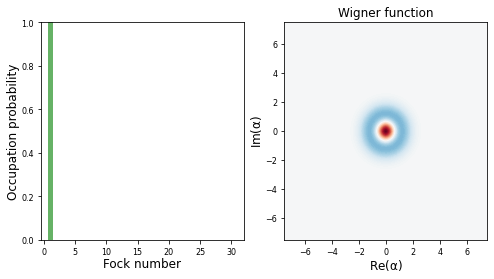

In [16]:
rho = fock_dm(hilbert_size, 1)
plot_wigner_fock_distribution(rho)
plt.show()

In [17]:
rho_tf = dm_to_tf([rho])
data = batched_expect(ops_batch, rho_tf)

In [18]:
x = tf.reshape(tf.cast(data, tf.float64), (1, num_grid, num_grid, 1))

conved = GaussianConv(gauss_kernel)(x)

kernel = gauss_kernel/tf.reduce_max(gauss_kernel)
diff = conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(conved) - kernel.numpy().reshape(num_grid,
                                                                                                 num_grid)
diff = tf.convert_to_tensor(diff)

matrices = [gauss_kernel.reshape((num_grid, num_grid)), x.numpy().reshape((num_grid, num_grid)), 
           conved.numpy().reshape((num_grid, num_grid)), diff.numpy().reshape((num_grid, num_grid))]

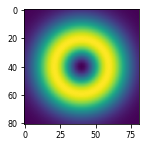

In [19]:
plt.imshow(diff)

In [20]:
datapath = "data/"
fname = datapath+"states-convolution-noise-fock.npy"
states_list = np.load(fname)

rho_tf = dm_to_tf([Qobj(states_list[-1])])
data_reconstructed = batched_expect(ops_batch, rho_tf)

reconstructed_x = tf.reshape(tf.cast(data_reconstructed, tf.float64), (1, num_grid, num_grid, 1))

reconstructed_conved = GaussianConv(gauss_kernel)(reconstructed_x)

diff2 = reconstructed_conved.numpy().reshape(num_grid, num_grid)/tf.reduce_max(reconstructed_conved) - kernel.numpy().reshape(num_grid, num_grid)

In [21]:
matrices2 = [gauss_kernel.reshape((num_grid, num_grid)), reconstructed_x.numpy().reshape((num_grid, num_grid)), 
           reconstructed_conved.numpy().reshape((num_grid, num_grid)), diff2.numpy().reshape((num_grid, num_grid))]

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/511329815.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[i].pcolor(xvec, yvec,
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/511329815.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(["", "", ""])
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/511329815.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(["", "", ""], fontsize=6)
/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_29819/511329815.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0

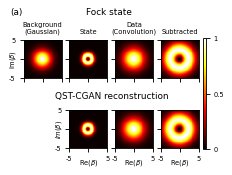

In [22]:
figpath = "figures/"

fig, ax = plt.subplots(2, 4, figsize=(fig_width, 0.35*2.5*fig_height), dpi=80, facecolor="white",
                             sharey=False, sharex=True)

axes = [ax[0, 0], ax[0, 1], ax[0, 2], ax[0, 3]]

aspect = 'equal'

for i in range(4):
    im = axes[i].pcolor(xvec, yvec,
                   matrices[i]/np.max(matrices[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["", "", ""])
    axes[i].set_yticklabels(["", "", ""], fontsize=6)
    # axes[i].set_xlabel(r"$Re(\beta)$", fontsize=6)    
axes[0].set_yticklabels(["-5", "", "5"], fontsize=6)

labels = ["Background\n(Gaussian)", "State", "Data\n(Convolution)", "Subtracted"]

for i in range(len(labels)):
    axes[i].set_title(labels[i], fontsize=6)

# plt.subplots_adjust(wspace=-.4)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])

axes[0].set_ylabel(r"Im$(\beta)$", labelpad=-8, fontsize=6)

plt.text(x = -24.5, y=30, s="Fock state", fontsize=8)

######################################################################################################

axes = [ax[1, 0], ax[1, 1], ax[1, 2], ax[1, 3]]

for i in range(1, 4):
    axes[i].pcolor(xvec, yvec,
                   matrices2[i]/np.max(matrices2[i]), cmap="hot", vmin=0, vmax=1)
    axes[i].set_aspect("equal")
    axes[i].set_xticklabels(["-5", "", "5"], fontsize=6)
    axes[i].set_yticklabels(["", "", ""])
    axes[i].set_xlabel(r"Re$(\beta)$", fontsize=6, labelpad=-4)    


labels = ["Background\n(Gaussian)", "Reconstructed\nState", r"$Convoluted\noutput$"+"\noutput", "Subtracted"]

# for i in range(1, len(labels)):
#     axes[i].set_title(labels[i], fontsize=6)

plt.subplots_adjust(hspace=0.7)
# cbar = fig.colorbar(im, ax=axes, pad=0.026, fraction = 0.046)
# cbar.ax.set_yticklabels(["0", "0.5", "1"])
plt.suptitle("QST-CGAN reconstruction", x=.45, y=.52, fontsize=8)

axes[1].set_ylabel(r"$Im(\beta)$", labelpad=-8, fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"], fontsize=6)
axes[1].set_yticklabels(["-5", "", "5"])
axes[0].set_visible(False)

cbar = plt.colorbar(im, ax=ax.ravel().tolist(), aspect=40, ticks=[0, 0.5, 1], pad=0.02)
cbar.set_ticklabels(["0", "0.5", "1"])
cbar.ax.tick_params(labelsize=6) 
plt.text(x = -44.5, y=30, s="(a)", fontsize=8)
plt.savefig(figpath+"fig-15a-fock-reconstruction.pdf", bbox_inches="tight", pad_inches=0)

In [23]:
print(fidelity(Qobj(states_list[-1]), rho))

0.992968997070247
